# Setup
This notebook is for plotting some simple metrics from an ultrasonic vocalization recording experiment using mouse pups temporarily isolated from their mother. `USV_notes.xlsx` contains subject data- most importantly it has columns for age and genotype, and a row for each recording. [DeepSqueak](https://github.com/DrCoffey/DeepSqueak) was used to detect and measure calls. Results were output to Excel files and saved in an `excel/` directory. Call data is stored in a dictionary, where the keys are recording IDs and the values are sub-dictionaries containing the full DeepSqueak output, the pup's age and genotype, and some statistical data.

In [18]:
# Input path to folder subject data and subdirectory containing call detection files from DeepSqueak
subject_data = "USV_notes.xlsx"
results_folder = "excel"
data_path = r'\\RDSMSB.OHSU.EDU\Vollum\Labs\JackmanLab\People\Chloe\Rotation\USV\USV_data'

# Packages

In [19]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  #turn off chained assignment warning
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import seaborn as sns
import scipy.stats as stats

# Import and organize data

In [20]:
#import subject data (pup IDs, ages, genotypes, weights, etc.)
pupdata = pd.read_excel(os.path.join(data_path, subject_data), index_col=10)

#check import
print(len(pupdata), 'pups found')
pupdata.head(3)

41 pups found


,Date,Cage,Genotype,Age (PND),Room temp (C),Box temp (C),Pup #,Cage temp (C),Start time,Gain setting,Weight (g),Notes
Log (T00000),,,,,,,,,,,,
12,2022-04-21,58,Syt7-/-,6,21,25,1,35.0,1:15PM,6,2.8,"removed parents at 1:00PM, they explored for a..."
13,2022-04-21,58,Syt7-/-,6,21,25,2,33.0,1:35PM,5,3.0,played around with gain for a bit during the f...
14,2022-04-21,58,Syt7-/-,6,21,25,3,35.0,1:48PM,5,2.9,not calling very much in the first few minutes...


In [21]:
#create dictionary for call data

path = os.path.join(data_path, results_folder)
filenames_list = []
d = {}  #dictionary; each key is one recording (one pup at a specific age), for which the value is a dataframe of call data

#import DeepSqueak excel files and add dataframe to pup dictionary
for filename in os.listdir(path):
    if filename.endswith('.xlsx'):
        f = filename.split(".")[0] #remove ext
        ID = int(f[6:8]) #get log file number (DeepSqueak output files are named like 'T0000012 2022-04-22  3_40 PM_Stats')
        df = pd.read_excel(os.path.join(path, filename), index_col=0, usecols=[i for i in range(17) if i not in [1,2]]) #***change to include label if I get the classification figured out***
        
        d[ID] = {'DS': df} #ID ends up being Log number as int
        d[ID]['Age'] = pupdata['Age (PND)'][ID]
        
print(len(d), 'files found:\n', list(d.keys()))

41 files found:
 [32, 17, 46, 56, 39, 49, 30, 51, 14, 18, 28, 37, 45, 36, 24, 43, 20, 41, 48, 52, 15, 19, 44, 31, 53, 54, 29, 57, 50, 13, 38, 55, 34, 40, 47, 23, 16, 21, 25, 35, 12]


In [22]:
#calc DeepSqueak (DS) means+SEMs and add to pup dictionary (d)

col_of_interest = ['Call Length (s)','Principal Frequency (kHz)', 'Low Freq (kHz)', 'High Freq (kHz)','Delta Freq (kHz)', 'Frequency Standard Deviation (kHz)','Slope (kHz/s)', 'Sinuosity', 'Mean Power (dB/Hz)', 'Tonality','Peak Freq (kHz)']
filtered = d[list(d.keys())[0]]['DS'].filter(col_of_interest)

means = pd.DataFrame(columns=filtered.columns)
SEMs = pd.DataFrame(columns=filtered.columns)
for k,v in d.items():
    means.loc[k] = d[k]['DS'].mean()
    SEMs.loc[k] = d[k]['DS'].sem()
SEMs = SEMs.add_suffix(' SEM')

for ID,row in pupdata.iterrows(): #i is index, and Log number
    if pupdata['Genotype'][ID][-3:] == '+/+': #if WT
        d[ID]['Group'] = 'WT'
    else:
        d[ID]['Group'] = pupdata['Genotype'][ID]
    d[ID]['means'] = means.loc[ID]
    d[ID]['SEMs'] = SEMs.loc[ID]

print('keys in pup dictionary: ', list(d[list(d.keys())[0]].keys()))

keys in pup dictionary:  ['DS', 'Age', 'Group', 'means', 'SEMs']


In [23]:
#print N's
pupdata.groupby(['Genotype', 'Cage', 'Age (PND)']).Cage.count()

Genotype  Cage  Age (PND)
DKO       41    6            5
Syt3+/+   62    11           4
          63    5            4
                9            4
                11           4
Syt3-/-   65    7            2
                9            2
                11           1
          67    5            2
                9            2
                11           2
Syt7-/-   58    6            9
Name: Cage, dtype: int64

# plotting

In [24]:
pal = sns.color_palette('colorblind')
colors = pal.as_hex()[0:4]
order = ['WT', 'Syt3-/-', 'Syt7-/-', 'DKO']
ages = pupdata['Age (PND)'].unique()
ages = np.sort(ages)

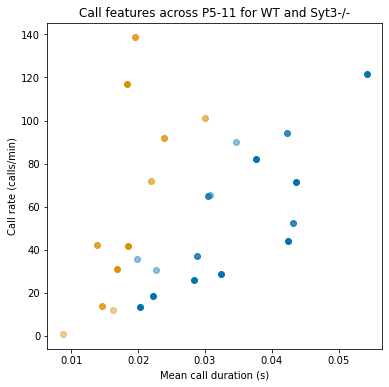

In [25]:
#call rate * mean duration for WT+Syt3
plt.figure(figsize=(6, 6))
for pup in d.keys():
    dur = d[pup]['means']['Call Length (s)']
    rate = len(d[pup]['DS'])/5
    a = d[pup]['Age']/11
    if d[pup]['Group']!='WT' and d[pup]['Group']!='Syt3-/-':
        continue
    elif d[pup]['Group']=='WT':
        plt.scatter(dur, rate, color=colors[0], alpha=a)
    else:
        plt.scatter(dur, rate, color=colors[1], alpha=a)
plt.xlabel('Mean call duration (s)')
plt.ylabel('Call rate (calls/min)');
plt.title('Call features across P5-11 for WT and Syt3-/-');

In [26]:
def plot_USVs(measure, pupdata=pupdata, d=d):
    '''
    measure = 'Call rate (calls/min)' or a column heading from 'means' df in pup dictionary:
        Call Length (s)
        Principal Frequency (kHz)
        Low Freq (kHz)
        High Freq (kHz)
        Delta Freq (kHz)
        Frequency Standard Deviation (kHz)
        Slope (kHz/s)
        Sinuosity
        Mean Power (dB/Hz)
        Tonality
        Peak Freq (kHz)
    [uses Sty3+/+ and Syt3 -/-; could add new variable for diff genotypes eventually]
    '''
    
    WT = pupdata.loc[pupdata['Genotype']=='Syt3+/+'].filter(['Age (PND)'])
    S3 = pupdata.loc[pupdata['Genotype']=='Syt3-/-'].filter(['Age (PND)'])

    ax = plt.axes()
    plt.figure(figsize=(6, 6))
    for pup in d.keys():
        
        age = d[pup]['Age']
        if measure=='Call rate (calls/min)': y=len(d[pup]['DS'])/5
        else: y=d[pup]['means'][measure]

        if d[pup]['Group']!='WT' and d[pup]['Group']!='Syt3-/-':
            continue
        elif d[pup]['Group']=='WT':
            ax.scatter(age, y, color=colors[0], alpha=0.5, marker='.')
            WT.loc[pup, 'mean '+measure] = y
        else:
            ax.scatter(age, y, color=colors[1], alpha=0.5, marker='.')
            S3.loc[pup, 'mean '+measure] = y

    WTplt = WT.groupby('Age (PND)').agg([np.mean, stats.sem]).droplevel(level=0, axis=1)
    S3plt = S3.groupby('Age (PND)').agg([np.mean, stats.sem]).droplevel(level=0, axis=1)
    WTplt.plot(y='mean', ax=ax, color=colors[0], marker='o', style='--', figsize=(6,6), yerr='sem', label='WT')
    S3plt.plot(y='mean', ax=ax, color=colors[1], marker='o', style='--', yerr='sem', label='Syt3-/-')

    ax.set_xlabel('Age (pnd)')
    ax.set_ylabel(measure)
    ax.title.set_text(measure+' across P5-11 for WT and Syt3-/-')
    ax.legend(loc=(1.1,0.5));

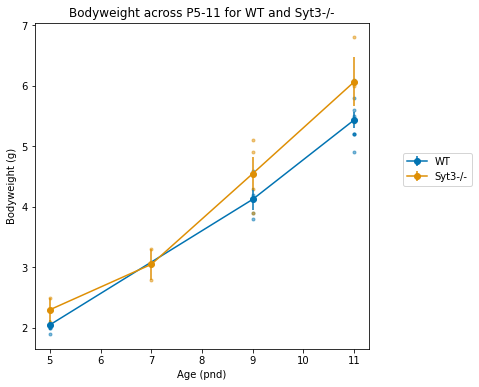

<Figure size 432x432 with 0 Axes>

In [27]:
WT = pupdata.loc[pupdata['Genotype']=='Syt3+/+'].filter(['Age (PND)'])
S3 = pupdata.loc[pupdata['Genotype']=='Syt3-/-'].filter(['Age (PND)'])

ax = plt.axes()
plt.figure(figsize=(6, 6));
for pup in d.keys():
    age = d[pup]['Age']
    y = pupdata['Weight (g)'][pup]
    if d[pup]['Group']!='WT' and d[pup]['Group']!='Syt3-/-':
        continue
    elif d[pup]['Group']=='WT':
        ax.scatter(age, y, color=colors[0], alpha=0.5, marker='.')
        WT.loc[pup, 'mean weight'] = y
    else:
        ax.scatter(age, y, color=colors[1], alpha=0.5, marker='.')
        S3.loc[pup, 'mean weight'] = y

WTplt = WT.groupby('Age (PND)').agg([np.mean, stats.sem]).droplevel(level=0, axis=1)
S3plt = S3.groupby('Age (PND)').agg([np.mean, stats.sem]).droplevel(level=0, axis=1)
WTplt.plot(y='mean', ax=ax, color=colors[0], marker='o', style='--', figsize=(6,6), yerr='sem', label='WT')
S3plt.plot(y='mean', ax=ax, color=colors[1], marker='o', style='--', yerr='sem', label='Syt3-/-')

ax.set_xlabel('Age (pnd)')
ax.set_ylabel('Bodyweight (g)')
ax.title.set_text('Bodyweight across P5-11 for WT and Syt3-/-')
ax.legend(loc=(1.1,0.5));

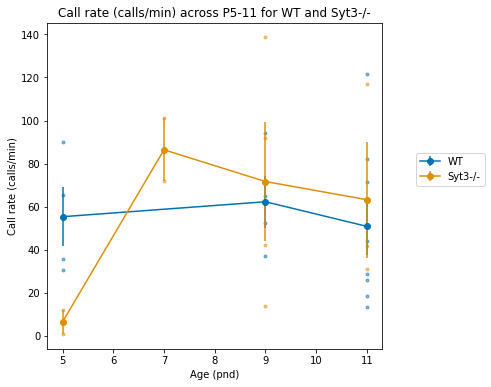

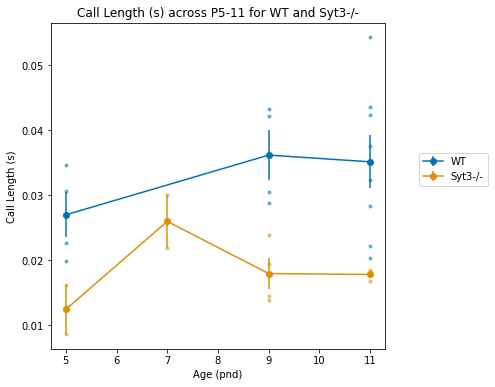

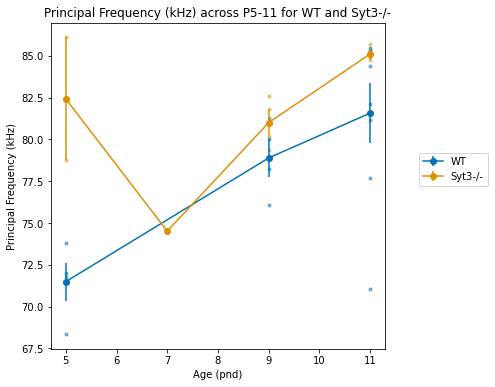

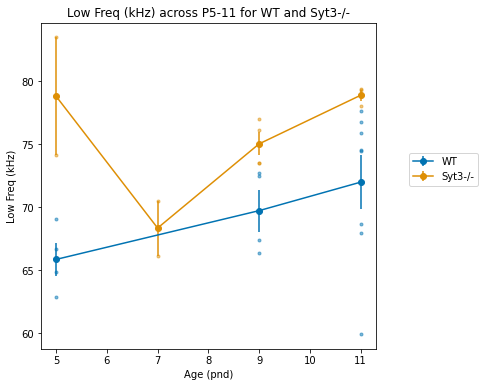

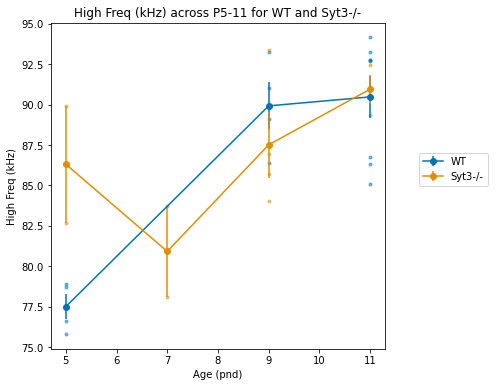

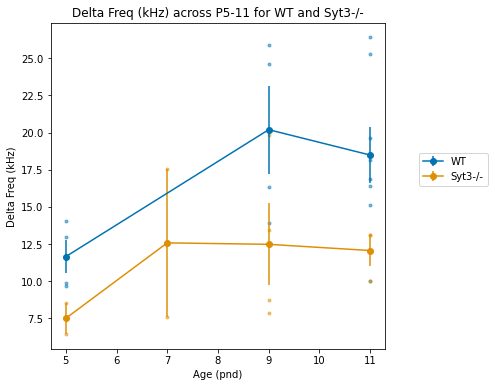

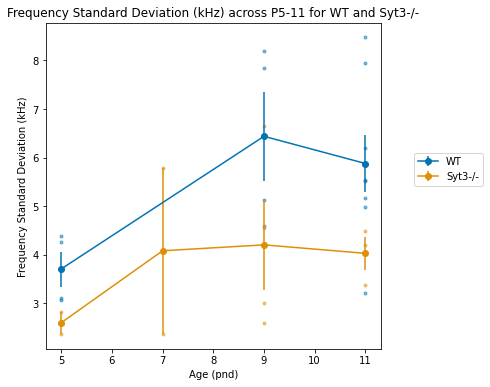

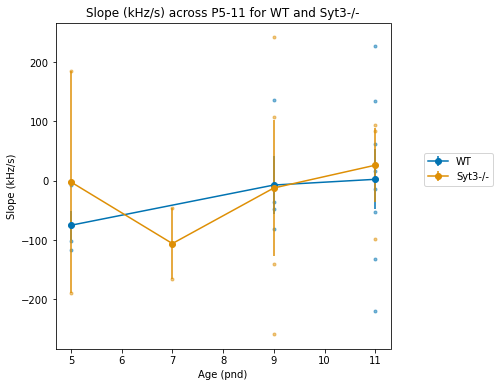

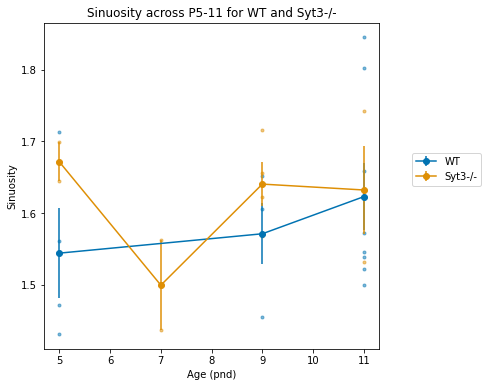

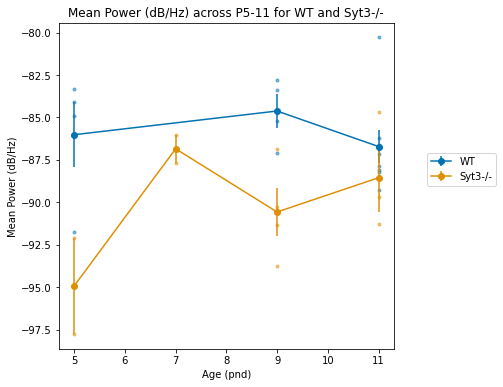

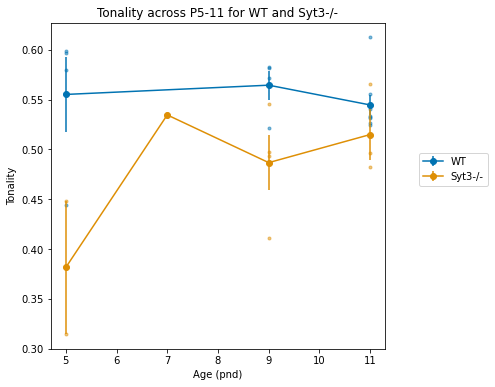

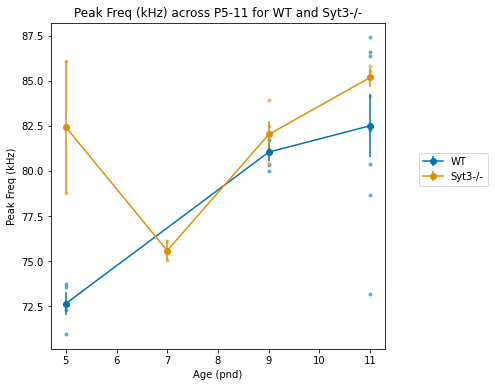

<Figure size 432x432 with 0 Axes>

In [28]:
#plot every feature across ages
plot_USVs('Call rate (calls/min)')

measures = list(d[12]['means'].index)
for i,m in enumerate(measures):
    plot_USVs(measures[i])

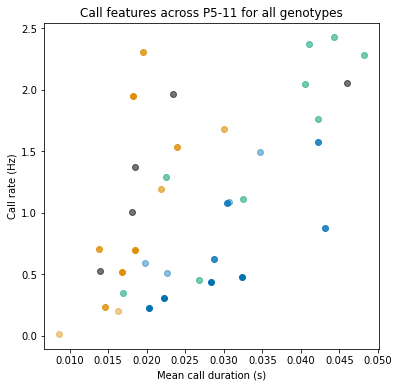

In [29]:
#call rate * mean duration for all genotypes
plt.figure(figsize=(6, 6))
for pup in d.keys():
    
    if pupdata['Cage'][pup]==62: continue #the extra cage of WTs I did
        
    dur = d[pup]['means']['Call Length (s)']
    rate = len(d[pup]['DS'])/300
    age = alpha=d[pup]['Age']/11
    geno = d[pup]['Group']
    if geno=='DKO': #had to separate bc it kept making DKO the same color as Syt3
        plt.scatter(dur, rate, color='k', alpha=age)
    else:
        plt.scatter(dur, rate, color=colors[order.index(geno)], alpha=age)

plt.xlabel('Mean call duration (s)')
plt.ylabel('Call rate (Hz)');
plt.title('Call features across P5-11 for all genotypes');

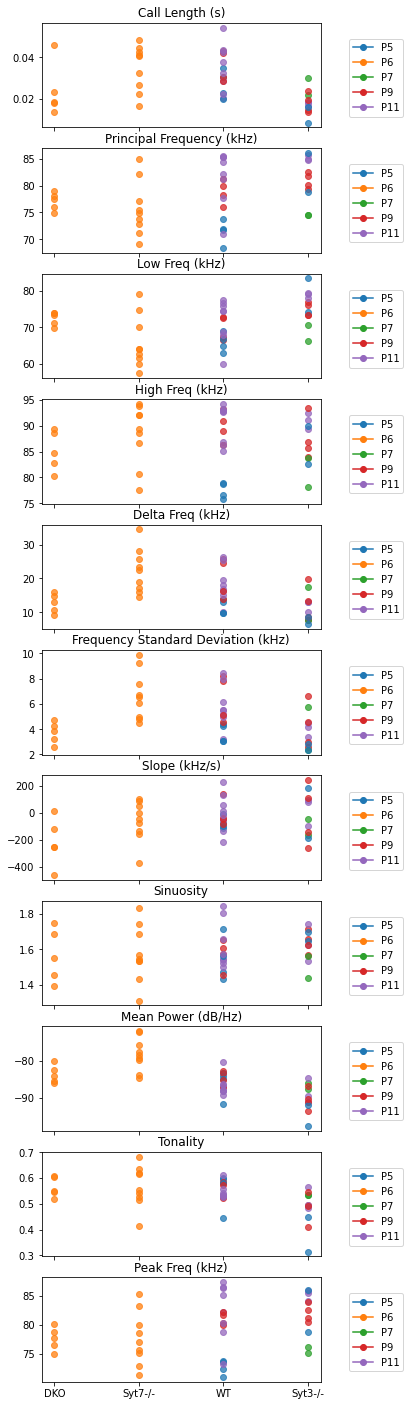

In [30]:
#one plot for each feature, genotype*mean; one datapoint per pup, color-coded by age

colors = pd.DataFrame({'age':ages, 'c':['C0', 'C1', 'C2', 'C3', 'C4']})

leg = []
for i in range(len(colors)):
    leg.append(Line2D([0],[0], marker='o', color=colors.loc[i]['c'], label='P'+str(colors.loc[i]['age'])))

f,ax = plt.subplots(len(d[12]['means'].index), figsize=(5,25), sharex=True)
for ct,i in enumerate(d[k]['means'].index):
    for k in d.keys():
        ax[ct].scatter(d[k]['Group'], d[k]['means'][i], c=colors['c'][colors['age']==pupdata['Age (PND)'][k]], alpha=0.75)
        ax[ct].title.set_text(i)
        ax[ct].legend(handles=leg, loc=(1.1,0.1))

# stats

In [31]:
#n's
groups = pupdata['Genotype'].unique()
cages = pupdata['Cage'].unique()
for gp in groups:
    for cg in cages:
        num_pups = len(pupdata.loc[(pupdata['Genotype']==gp)&(pupdata['Cage']==cg)])
        if num_pups==0:
            continue
        print(cg, gp, num_pups)

58 Syt7-/- 9
62 Syt3+/+ 4
63 Syt3+/+ 12
41 DKO 5
67 Syt3-/- 6
65 Syt3-/- 5


### call rate

In [32]:
#normality

rates = pupdata.filter(['Genotype', 'Age (PND)'])
for pup in d.keys():
    rates.loc[pup, 'call rate'] = len(d[pup]['DS'])/5

stat,p = stats.shapiro(rates['call rate'])
print('all ages:',p)

for age in ages:
    if age==7: #not enough data; n=2
        continue
    if age==6:
        continue
    #stat,p = stats.shapiro(rates.loc[rates['Age (PND)']==age, 'call rate'])
    stat,p = stats.shapiro(rates.loc[(rates['Age (PND)']==age)&(rates['Genotype']!='Syt7-/-')&(rates['Genotype']!='DKO'), 'call rate'])
    print('P',age,':',p)

all ages: 0.039499226957559586
P 5 : 0.7513995170593262
P 9 : 0.8151832222938538
P 11 : 0.06988357752561569


In [33]:
#weights
for age in ages:
    if age==7: #not enough data; n=2
        continue
    if age==6:
        continue
    #stat,p = stats.shapiro(rates.loc[rates['Age (PND)']==age, 'call rate'])
    stat,p = stats.shapiro(pupdata.loc[(pupdata['Age (PND)']==age)&(pupdata['Genotype']!='Syt7-/-')&(pupdata['Genotype']!='DKO'), 'Weight (g)'])
    print('P',age,':',p)

P 5 : 0.404415100812912
P 9 : 0.38096916675567627
P 11 : 0.39181458950042725


In [34]:
#weights
WT = pupdata.loc[pupdata['Genotype']=='Syt3+/+']
S3 = pupdata.loc[pupdata['Genotype']=='Syt3-/-']
#stat,p = stats.mannwhitneyu(WT['Weight (g)'], S3['Weight (g)'])
#print('all ages (M-W):',p)

for age in [5,9,11]:
    stat,p = stats.ttest_ind(WT.loc[WT['Age (PND)']==age, 'Weight (g)'], S3.loc[S3['Age (PND)']==age, 'Weight (g)'])
    print('P',age,'(TT):',p)

P 5 (TT): 0.2340231253992753
P 9 (TT): 0.24372905026480157
P 11 (TT): 0.08304407577482867


In [35]:
#t-tests
WT = rates.loc[rates['Genotype']=='Syt3+/+']
S3 = rates.loc[rates['Genotype']=='Syt3-/-']
stat,p = stats.mannwhitneyu(WT['call rate'],S3['call rate'])
print('all ages (M-W):',p)

for age in [5,9,11]:
    stat,p = stats.ttest_ind(WT.loc[WT['Age (PND)']==age, 'call rate'], S3.loc[S3['Age (PND)']==age, 'call rate'])
    print('P',age,'(TT):',p)

all ages (M-W): 0.8628775594244169
P 5 (TT): 0.08086076748117998
P 9 (TT): 0.7653761649878649
P 11 (TT): 0.657801980113727


### call durations + other features

In [36]:
def norm_USVs(measure):
    
    means = pupdata.filter(['Genotype', 'Age (PND)'])
    for pup in d.keys():
        means.loc[pup, 'mean'] = d[pup]['means'][measure]

    stat,p = stats.shapiro(means['mean'])
    print(measure)
    print('  all ages:',p)

    for age in ages:
        if age==7: #not enough data; n=2
            continue
        if age==6:
            continue
        #stat,p = stats.shapiro(rates.loc[rates['Age (PND)']==age, 'call rate'])
        stat,p = stats.shapiro(rates.loc[(rates['Age (PND)']==age)&(rates['Genotype']!='Syt7-/-')&(rates['Genotype']!='DKO'), 'call rate'])
        print('  P',age,':',p)

In [37]:
#normality for WT + Syt3
measures = list(d[12]['means'].index)
for i,m in enumerate(measures):
    norm_USVs(measures[i])

Call Length (s)
  all ages: 0.04078177735209465
  P 5 : 0.7513995170593262
  P 9 : 0.8151832222938538
  P 11 : 0.06988357752561569
Principal Frequency (kHz)
  all ages: 0.11455938965082169
  P 5 : 0.7513995170593262
  P 9 : 0.8151832222938538
  P 11 : 0.06988357752561569
Low Freq (kHz)
  all ages: 0.5313423871994019
  P 5 : 0.7513995170593262
  P 9 : 0.8151832222938538
  P 11 : 0.06988357752561569
High Freq (kHz)
  all ages: 0.010831412859261036
  P 5 : 0.7513995170593262
  P 9 : 0.8151832222938538
  P 11 : 0.06988357752561569
Delta Freq (kHz)
  all ages: 0.05032093822956085
  P 5 : 0.7513995170593262
  P 9 : 0.8151832222938538
  P 11 : 0.06988357752561569
Frequency Standard Deviation (kHz)
  all ages: 0.042042773216962814
  P 5 : 0.7513995170593262
  P 9 : 0.8151832222938538
  P 11 : 0.06988357752561569
Slope (kHz/s)
  all ages: 0.835522472858429
  P 5 : 0.7513995170593262
  P 9 : 0.8151832222938538
  P 11 : 0.06988357752561569
Sinuosity
  all ages: 0.8450700640678406
  P 5 : 0.751399

In [38]:
def get_features(feature):

    WT = pupdata.loc[pupdata['Genotype']=='Syt3+/+'].filter(['Age (PND)'])
    S3 = pupdata.loc[pupdata['Genotype']=='Syt3-/-'].filter(['Age (PND)'])

    for pup in d.keys():
        y=d[pup]['means'][feature]
        age = d[pup]['Age']
        
        if d[pup]['Group']!='WT' and d[pup]['Group']!='Syt3-/-':
            continue
        elif d[pup]['Group']=='WT':
            WT.loc[pup, 'mean '+feature] = y
        else:
            S3.loc[pup, 'mean '+feature] = y
    return WT,S3

In [39]:
WT, S3 = get_features('Call Length (s)')
for age in WT['Age (PND)'].unique():
    st,p = stats.mannwhitneyu(WT.loc[WT['Age (PND)']==age, 'mean Call Length (s)'].values, S3.loc[S3['Age (PND)']==age, 'mean Call Length (s)'].values)
    print('P', age, ' p =', p)

P 11  p = 0.012121212121212121
P 5  p = 0.13333333333333333
P 9  p = 0.02857142857142857


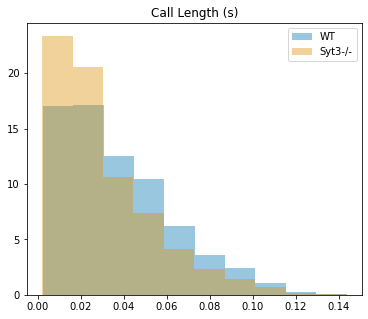

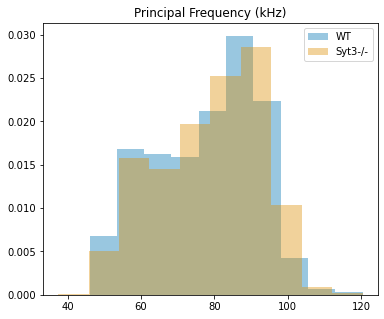

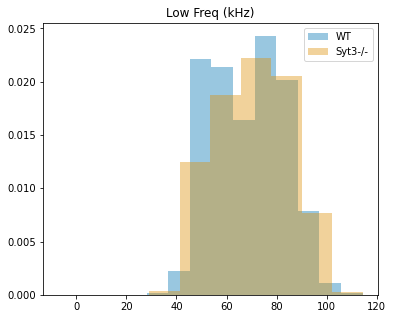

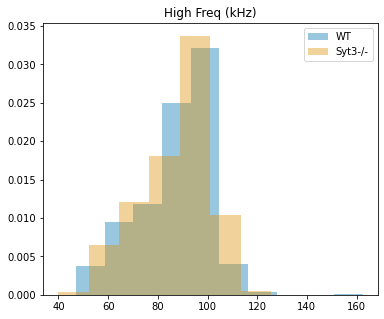

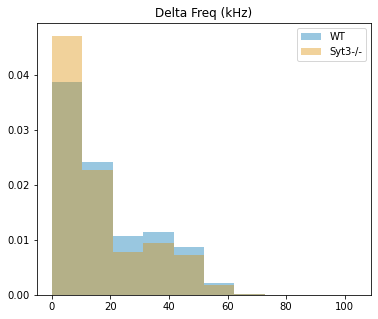

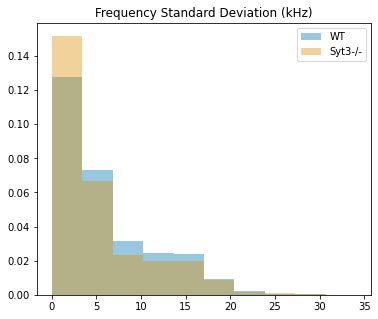

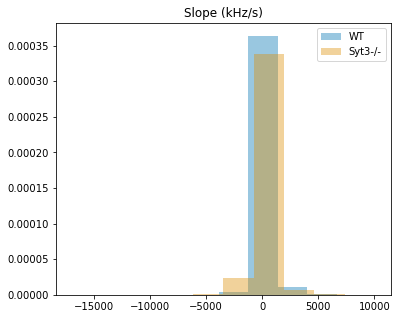

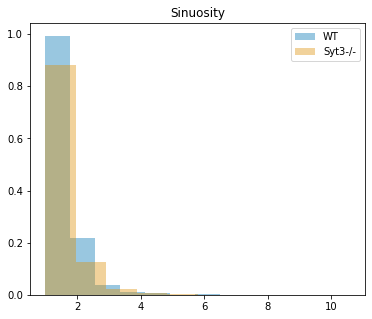

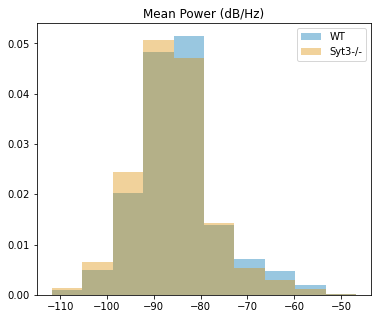

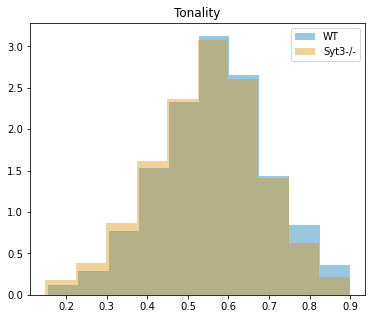

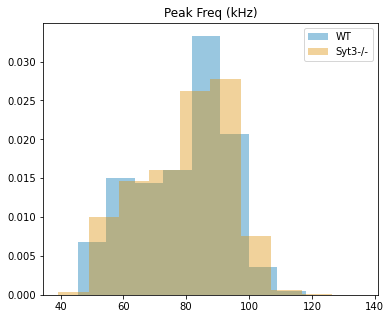

In [41]:
#overlapping histograms of features
colors = pal.as_hex()[0:4]

measures = list(d[12]['means'].index)
for i,m in enumerate(measures):
    plt.figure(figsize=(6,5))
    allpups = list()
    for c,gp in enumerate(['WT', 'Syt3-/-']): #could do this fancier and faster with list comprehension-style nested dictionary filtering 
        for pup in d.keys():
            if d[pup]['Group']!=gp:
                continue
            else:
                allpups += list(d[pup]['DS'][measures[i]].values)
        plt.hist(allpups, alpha=0.4, label=gp, density=True, color=colors[c])
        plt.title(measures[i])
    plt.legend()

In [146]:
pupdata.loc[pupdata['Genotype']=='Syt3-/-']

,Date,Cage,Genotype,Age (PND),Room temp (C),Box temp (C),Pup #,Cage temp (C),Start time,Gain setting,Weight (g),Notes
Log (T00000),,,,,,,,,,,,
34,2022-04-28,67,Syt3-/-,5,21,25,1,33.0,1:32PM,4,2.5,"separated parents at 1:17PM, they explored the..."
35,2022-04-28,67,Syt3-/-,5,21,25,2,34.0,1:40PM,4,2.1,silent similar to first pup; some movement noi...
40,2022-05-02,67,Syt3-/-,9,21,25,1,33.0,2:30PM,4,5.1,"removed parents at 2:16PM, they're exploring; ..."
41,2022-05-02,67,Syt3-/-,9,21,25,2,34.0,2:38PM,4,4.3,few very short and quiet calls in the beginnin...
43,2022-05-02,65,Syt3-/-,7,21,25,1,33.0,4:29PM,4,2.8,removed parents at 4:14PM; they're exploring (...
44,2022-05-02,65,Syt3-/-,7,21,25,2,35.0,4:37PM,4,3.3,"solid calling, some strong enough to be clearl..."
49,2022-05-04,65,Syt3-/-,9,21,25,1,33.0,1:47PM,4,3.9,"removed parents at 1:36PM, they're jumpy; lots..."
50,2022-05-04,65,Syt3-/-,9,21,25,2,34.0,1:55PM,4,4.9,calling frequently; some noisy ones around 90s...
51,2022-05-04,67,Syt3-/-,11,21,25,1,33.0,2:15PM,4,6.8,"removed parents at 2:05PM, they're large and j..."


In [ ]:
measure = 'Call Length (s)'

colors = pal.as_hex()[0:4]

WT = pupdata.loc[pupdata['Genotype']=='Syt3+/+'].filter(['Genotype'])
S3 = pupdata.loc[(pupdata['Genotype']=='Syt3-/-') & (pupdata['Age (PND)']!=7)].filter(['Genotype']).dropna()

plt.figure(figsize=[4,4]);
ax = plt.axes()

for pup in d.keys():

    geno = d[pup]['Group']
    y=d[pup]['means'][measure]

    if d[pup]['Group']!='WT' and d[pup]['Group']!='Syt3-/-':
        continue
    elif d[pup]['Group']=='WT':
        ax.scatter(geno, y, color=colors[0], marker='.');
        WT.loc[pup, 'mean '+measure] = y
    else:
        ax.scatter(geno, y, color=colors[1], marker='.');
        S3.loc[pup, 'mean '+measure] = y

combinedata = pd.concat([WT, S3]).dropna()
plotdata = combinedata.groupby('Genotype').agg([np.mean, stats.sem]).droplevel(level=0, axis=1)
plotdata.plot(kind='bar', y='mean', ax=ax, alpha=0.5, color=colors[0:2]);

        
ax.set_xlabel('Genotype');
ax.set_ylabel('Mean call duration (s)');
ax.title.set_text('Call Length');
ax.get_legend().remove();
ax.tick_params(axis='x', labelrotation=0);



plotdata.plot.bar(y='mean',yerr='sem', color=colors[0:2], figsize=[4,4], legend=False);
plt.xticks(rotation = 0);
plt.ylabel('Mean call duration (s)');
plt.xlabel('Genotype');
plt.title('Call Length');


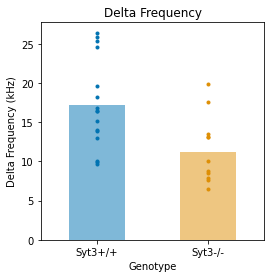

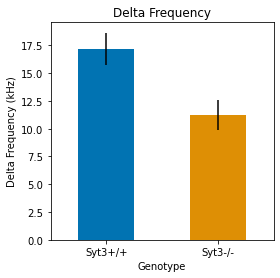

In [111]:
measure = 'Delta Freq (kHz)'

colors = pal.as_hex()[0:4]

WT = pupdata.loc[pupdata['Genotype']=='Syt3+/+'].filter(['Genotype'])
S3 = pupdata.loc[(pupdata['Genotype']=='Syt3-/-') & (pupdata['Age (PND)']!=7)].filter(['Genotype']).dropna()

plt.figure(figsize=[4,4]);
ax = plt.axes()

for pup in d.keys():

    geno = d[pup]['Group']
    y=d[pup]['means'][measure]

    if d[pup]['Group']!='WT' and d[pup]['Group']!='Syt3-/-':
        continue
    elif d[pup]['Group']=='WT':
        ax.scatter(geno, y, color=colors[0], marker='.');
        WT.loc[pup, 'mean '+measure] = y
    else:
        ax.scatter(geno, y, color=colors[1], marker='.');
        S3.loc[pup, 'mean '+measure] = y

combinedata = pd.concat([WT, S3]).dropna()
plotdata = combinedata.groupby('Genotype').agg([np.mean, stats.sem]).droplevel(level=0, axis=1)
plotdata.plot(kind='bar', y='mean', ax=ax, alpha=0.5, color=colors[0:2]);

        
ax.set_xlabel('Genotype');
ax.set_ylabel('Delta Frequency (kHz)');
ax.title.set_text('Delta Frequency');
ax.get_legend().remove();
ax.tick_params(axis='x', labelrotation=0);



plotdata.plot.bar(y='mean',yerr='sem', color=colors[0:2], figsize=[4,4], legend=False);
plt.xticks(rotation = 0);
plt.ylabel('Delta Frequency (kHz)');
plt.xlabel('Genotype');
plt.title('Delta Frequency');

#data pooled for PND 5,9,11
#t-test: p = 0.00971

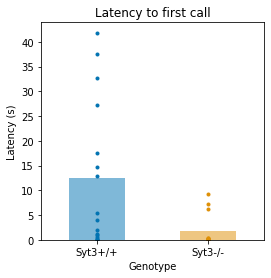

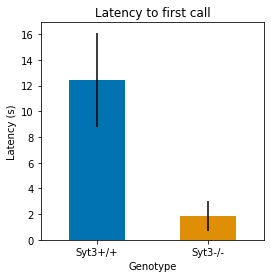

In [137]:
colors = pal.as_hex()[0:4]

WT = pupdata.loc[pupdata['Genotype']=='Syt3+/+'].filter(['Genotype'])
S3 = pupdata.loc[(pupdata['Genotype']=='Syt3-/-') & (pupdata['Age (PND)']!=7)].filter(['Genotype']).dropna()

plt.figure(figsize=[4,4])
ax = plt.axes()

for pup in d.keys():

    geno = d[pup]['Group']
    y=d[pup]['DS']['Begin Time (s)'][1]

    if d[pup]['Group']!='WT' and d[pup]['Group']!='Syt3-/-':
        continue
    elif d[pup]['Group']=='WT':
        ax.scatter(geno, y, color=colors[0], marker='.');
        WT.loc[pup, 'mean '+measure] = y
    else:
        ax.scatter(geno, y, color=colors[1], marker='.');
        S3.loc[pup, 'mean '+measure] = y

combinedata = pd.concat([WT, S3]).dropna()
plotdata = combinedata.groupby('Genotype').agg([np.mean, stats.sem]).droplevel(level=0, axis=1)
plotdata.plot(kind='bar', y='mean', ax=ax, alpha=0.5, color=colors[0:2]);

        
ax.set_xlabel('Genotype');
ax.set_ylabel('Latency (s)');
ax.title.set_text('Latency to first call');
ax.get_legend().remove();
ax.tick_params(axis='x', labelrotation=0);



plotdata.plot.bar(y='mean',yerr='sem', color=colors[0:2], figsize=[4,4], legend=False);
plt.xticks(rotation = 0);
plt.ylabel('Latency (s)');
plt.xlabel('Genotype');
plt.title('Latency to first call');

#data pooled for PND 5,9,11
#mann-whitney: p = 0.0167

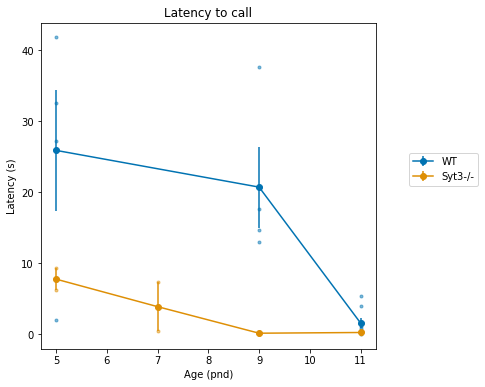

<Figure size 432x432 with 0 Axes>

In [233]:
WT = pupdata.loc[pupdata['Genotype']=='Syt3+/+'].filter(['Age (PND)'])
S3 = pupdata.loc[pupdata['Genotype']=='Syt3-/-'].filter(['Age (PND)'])

ax = plt.axes()
plt.figure(figsize=(6, 6));
for pup in d.keys():
    age = d[pup]['Age']
    y = d[pup]['DS']['Begin Time (s)'][1]
    if d[pup]['Group']!='WT' and d[pup]['Group']!='Syt3-/-':
        continue
    elif d[pup]['Group']=='WT':
        ax.scatter(age, y, color=colors[0], alpha=0.5, marker='.')
        WT.loc[pup, 'mean weight'] = y
    else:
        ax.scatter(age, y, color=colors[1], alpha=0.5, marker='.')
        S3.loc[pup, 'mean weight'] = y

WTplt = WT.groupby('Age (PND)').agg([np.mean, stats.sem]).droplevel(level=0, axis=1)
S3plt = S3.groupby('Age (PND)').agg([np.mean, stats.sem]).droplevel(level=0, axis=1)
WTplt.plot(y='mean', ax=ax, color=colors[0], marker='o', style='--', figsize=(6,6), yerr='sem', label='WT')
S3plt.plot(y='mean', ax=ax, color=colors[1], marker='o', style='--', yerr='sem', label='Syt3-/-')

ax.set_xlabel('Age (pnd)')
ax.set_ylabel('Latency (s)')
ax.title.set_text('Latency to call')
ax.legend(loc=(1.1,0.5));

In [230]:
feature = 'Call Length (s)'

WT = pupdata.loc[pupdata['Genotype']=='Syt3+/+'].filter(['Genotype'])
S3 = pupdata.loc[(pupdata['Genotype']=='Syt3-/-') & (pupdata['Age (PND)']!=7)].filter(['Genotype']).dropna()

for pup in d.keys():
    y=d[pup]['means'][feature]
    age = d[pup]['Age']

    if d[pup]['Group']!='WT' and d[pup]['Group']!='Syt3-/-':
        continue
    elif d[pup]['Group']=='WT':
        WT.loc[pup, 'mean duration'] = y
    else:
        S3.loc[pup, 'mean duration'] = y

st,p = stats.mannwhitneyu(WT['mean duration'].values, S3['mean duration'].values)
print(' p =', p)

#mann-whitney test (shapiro result was sig i.e. not normal)

 p = 0.0001948114248169812


In [238]:
#latency normality test
means = pupdata.loc[(pupdata['Genotype']=='Syt3-/-') | (pupdata['Genotype']=='Syt3+/+')].filter(['Genotype', 'Age (PND)'])
for pup in d.keys():
    means.loc[pup, 'mean'] = d[pup]['DS']['Begin Time (s)'][1]

stat,p = stats.shapiro(means['mean'])
print(measure)
print('  all ages:',p)

for age in ages:
    if age==7: #not enough data; n=2
        continue
    if age==6:
        continue
    #stat,p = stats.shapiro(rates.loc[rates['Age (PND)']==age, 'call rate'])
    stat,p = stats.shapiro(rates.loc[(rates['Age (PND)']==age)&(rates['Genotype']!='Syt7-/-')&(rates['Genotype']!='DKO'), 'call rate'])
    print('  P',age,':',p)

Call Length (s)
  all ages: 7.159133730283429e-09
  P 5 : 0.7513995170593262
  P 9 : 0.8151832222938538
  P 11 : 0.06988357752561569


In [231]:
WT = pupdata.loc[pupdata['Genotype']=='Syt3+/+'].filter(['Genotype'])
S3 = pupdata.loc[(pupdata['Genotype']=='Syt3-/-') & (pupdata['Age (PND)']!=7)].filter(['Genotype']).dropna()

for pup in d.keys():
    y=d[pup]['DS']['Begin Time (s)'][1]
    age = d[pup]['Age']

    if d[pup]['Group']!='WT' and d[pup]['Group']!='Syt3-/-':
        continue
    elif d[pup]['Group']=='WT':
        WT.loc[pup, 'mean'] = y
    else:
        S3.loc[pup, 'mean'] = y

st,p = stats.mannwhitneyu(WT['mean'].values, S3['mean'].values)
print(' p =', p)

#mann-whitney test

 p = 0.016697614260160337


In [141]:
plotdata

,mean,sem
Genotype,,
Syt3+/+,17.206558,1.433480
Syt3-/-,11.236933,1.372789


In [114]:
#delta normality test
means = pupdata.loc[(pupdata['Genotype']=='Syt3-/-') | (pupdata['Genotype']=='Syt3+/+')].filter(['Genotype', 'Age (PND)'])
for pup in d.keys():
    means.loc[pup, 'mean'] = d[pup]['DS']['Begin Time (s)'][1]

In [119]:
stat,p = stats.shapiro(combinedata['mean Delta Freq (kHz)'])
print('  all ages:',p)

  all ages: 0.07065966725349426


In [123]:
stats.ttest_ind(WT['mean Delta Freq (kHz)'], S3['mean Delta Freq (kHz)'])

Ttest_indResult(statistic=2.7997762603439353, pvalue=0.009714850380883178)

In [ ]:


stat,p = stats.shapiro(means['mean'])
print('  all ages:',p)

for age in ages:
    if age==7: #not enough data; n=2
        continue
    if age==6:
        continue
    #stat,p = stats.shapiro(rates.loc[rates['Age (PND)']==age, 'call rate'])
    stat,p = stats.shapiro(rates.loc[(rates['Age (PND)']==age)&(rates['Genotype']!='Syt7-/-')&(rates['Genotype']!='DKO'), 'call rate'])
    print('  P',age,':',p)

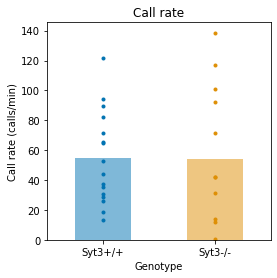

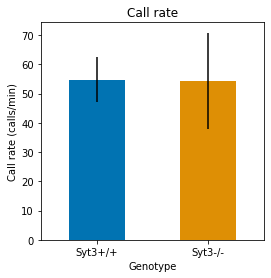

In [162]:
WT = pupdata.loc[pupdata['Genotype']=='Syt3+/+'].filter(['Genotype'])
S3 = pupdata.loc[(pupdata['Genotype']=='Syt3-/-') & (pupdata['Age (PND)']!=7)].filter(['Genotype']).dropna()
plt.figure(figsize=[4,4]);
ax = plt.axes()
for pup in d.keys():

    geno = d[pup]['Group']
    call_rate = len(d[pup]['DS'])/5

    if d[pup]['Group']!='WT' and d[pup]['Group']!='Syt3-/-':
        continue
    elif d[pup]['Group']=='WT':
        ax.scatter(geno, call_rate, color=colors[0], marker='.');
        WT.loc[pup, 'call rate'] = call_rate
    else:
        ax.scatter(geno, call_rate, color=colors[1], marker='.');
        S3.loc[pup, 'call rate'] = call_rate

combinedata = pd.concat([WT, S3]).dropna()
plotdata = combinedata.groupby('Genotype').agg([np.mean, stats.sem]).droplevel(level=0, axis=1)
plotdata.plot(kind='bar', y='mean', ax=ax, alpha=0.5, color=colors[0:2]);

        
ax.set_xlabel('Genotype');
ax.set_ylabel('Call rate (calls/min)');
ax.title.set_text('Call rate');
ax.get_legend().remove();
ax.tick_params(axis='x', labelrotation=0);


plotdata.plot.bar(y='mean',yerr='sem', color=colors[0:2], figsize=[4,4], legend=False);
plt.xticks(rotation = 0);
plt.ylabel('Call rate (calls/min)');
plt.xlabel('Genotype');
plt.title('Call rate');

In [161]:
combinedata

,Genotype,call rate
Log (T00000),,
21,Syt3+/+,121.8
23,Syt3+/+,44.2
24,Syt3+/+,71.6
25,Syt3+/+,82.0
36,Syt3+/+,35.6
37,Syt3+/+,89.8
38,Syt3+/+,30.4
39,Syt3+/+,65.4
45,Syt3+/+,94.4


In [150]:
plotdata

,mean,sem
Genotype,,
Syt3+/+,54.787500,7.756018
Syt3-/-,54.333333,16.487099


# Plot by frequency thresholds

In [42]:
WT = pupdata.loc[pupdata['Genotype']=='Syt3+/+'].filter(['Genotype'])
S3 = pupdata.loc[(pupdata['Genotype']=='Syt3-/-') & (pupdata['Age (PND)']!=7)].filter(['Genotype']).dropna()

measure = 'Delta Freq (kHz)'
threshold = 10

for pup in d.keys():
    df = d[pup]['DS']
    
    total = len(df)
    high = len(df[df[measure]>threshold])
    low = len(df[df[measure]<threshold])
    
    if d[pup]['Group']!='WT' and d[pup]['Group']!='Syt3-/-': continue
    elif d[pup]['Group']=='WT':
        WT.loc[pup, 'total calls'] = total
        WT.loc[pup, 'high calls'] = high
        WT.loc[pup, 'low calls'] = low
    else:
        S3.loc[pup, 'total calls'] = total
        S3.loc[pup, 'high calls'] = high
        S3.loc[pup, 'low calls'] = low

Text(0.5, 1.0, 'Delta Freq (kHz) [total, >10kHz, <10kHz]')

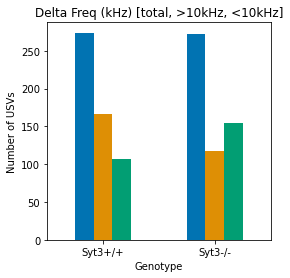

In [43]:
combinedata = pd.concat([WT, S3]).dropna()
plotdata = combinedata.groupby('Genotype').agg([np.mean, stats.sem]).droplevel(level=0, axis=1)

plotdata.plot.bar(y='mean',yerr='sem', color=colors[0:3], figsize=[4,4], legend=False);
plt.xticks(rotation = 0);
plt.ylabel('Number of USVs');
plt.xlabel('Genotype');
plt.title(f"{measure} [total, >{threshold}kHz, <{threshold}kHz]")